In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
# Om			\Omega_m
# Obh2			\Omega_{b}h^2
# h	
datafile = 'chains/LCDM_phy_HD_nested_dynesty_multi_1.txt'

In [4]:
class LoadDataSet(torch.utils.data.Dataset):
    '''
    Prepare the dataset for regression
    '''
    def __init__(self, X, y, scale_data=True):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [5]:
class MLP(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self):
        super().__init__()
        ncols = 3
        self.layers = nn.Sequential(
          nn.Linear(ncols, 200),
          nn.ReLU(),
          nn.Linear(200, 200),
          nn.ReLU(),
          nn.Linear(200, 1)
        )


    def forward(self, x):
        '''
          Forward pass
        '''
        return self.layers(x)

In [6]:
if __name__ == '__main__':
    # Set fixed random number seed
    torch.manual_seed(42)
  
    # Load Boston dataset
    X = np.loadtxt(datafile, usecols=(2,3,4))
    y = np.loadtxt(datafile, usecols=1).reshape(-1, 1)
    randomize = np.random.permutation(len(X))
    X = X[randomize]
    y = y[randomize]
    print(np.shape(X), np.shape(y))
    X_test, y_test = X[:100, :], y[:100, :]
    X, y = X[100:, :], y[100:, :]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

(1036, 3) (1036, 1)


In [7]:
dataset_train = LoadDataSet(X_train, y_train)
dataset_val = LoadDataSet(X_val, y_val)
# dataset_test = LoadDataSet(X_test, y_test)
X_test, y_test = torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

In [8]:
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=10, shuffle=True, num_workers=1)
validloader = torch.utils.data.DataLoader(dataset_val, batch_size=10, shuffle=True, num_workers=1)

In [9]:
# Initialize the MLP
mlp = MLP()
mlp.float()
# Define the loss function and optimizer
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

In [10]:
summary(mlp, batch_size=-1)

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       800
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       40,200
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       201
Total params: 41,201
Trainable params: 41,201
Non-trainable params: 0

In [11]:
# Run the training loop
history_train = np.empty((1,))
history_val = np.empty((1,))
for epoch in range(0, 100): # 5 epochs at maximum  
    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):

          # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 10 == 0:
            print('Loss after mini-batch %5d: %.3f' %
#                 (i + 1, current_loss / 500))
                  (i + 1, loss.item()))
            current_loss = 0.0
    history_train = np.append(history_train, current_loss)

    
    valid_loss = 0.0
    mlp.eval()     # Optional when not using Model Specific layer
    for i, data in enumerate(validloader, 0):
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        
        output_val = mlp(inputs)
        valid_loss = loss_function(output_val, targets)
    
        valid_loss += loss.item()
    history_val = np.append(history_val, valid_loss.item())
    print('Training Loss: {:.3f} \t\t Validation Loss:'\
         '{:.3f}'.format(loss.item(), valid_loss.item()))
#     print('Training Loss: {:.3f} \t\t Validation Loss:'\
#           '{:.3f}'.format(current_loss / len(trainloader), valid_loss / len(validloader)))
#     if min_valid_loss > valid_loss:
#         print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
#         min_valid_loss = valid_loss
#         # Saving State Dict
#         torch.save(model.state_dict(), 'saved_model.pth')

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch     1: 17.874
Loss after mini-batch    11: 15.234
Loss after mini-batch    21: 13.711
Loss after mini-batch    31: 7.808
Loss after mini-batch    41: 10.769
Loss after mini-batch    51: 21.282
Loss after mini-batch    61: 20.683
Loss after mini-batch    71: 12.503
Training Loss: 19.789 		 Validation Loss:31.927
Starting epoch 2
Loss after mini-batch     1: 7.829
Loss after mini-batch    11: 12.825
Loss after mini-batch    21: 6.663
Loss after mini-batch    31: 6.700
Loss after mini-batch    41: 5.545
Loss after mini-batch    51: 10.091
Loss after mini-batch    61: 8.777
Loss after mini-batch    71: 5.741
Training Loss: 7.286 		 Validation Loss:18.048
Starting epoch 3
Loss after mini-batch     1: 13.845
Loss after mini-batch    11: 9.735
Loss after mini-batch    21: 5.536
Loss after mini-batch    31: 4.321
Loss after mini-batch    41: 2.700
Loss after mini-batch    51: 4.253
Loss after mini-batch    61: 3.719
Loss after mini-batch    71: 2.420
Trai

Training Loss: 1.150 		 Validation Loss:2.594
Starting epoch 25
Loss after mini-batch     1: 1.405
Loss after mini-batch    11: 1.366
Loss after mini-batch    21: 0.439
Loss after mini-batch    31: 0.285
Loss after mini-batch    41: 0.433
Loss after mini-batch    51: 0.388
Loss after mini-batch    61: 0.216
Loss after mini-batch    71: 0.410
Training Loss: 1.031 		 Validation Loss:1.338
Starting epoch 26
Loss after mini-batch     1: 1.628
Loss after mini-batch    11: 0.432
Loss after mini-batch    21: 3.358
Loss after mini-batch    31: 1.280
Loss after mini-batch    41: 0.282
Loss after mini-batch    51: 0.423
Loss after mini-batch    61: 0.249
Loss after mini-batch    71: 2.389
Training Loss: 4.423 		 Validation Loss:5.760
Starting epoch 27
Loss after mini-batch     1: 0.382
Loss after mini-batch    11: 3.510
Loss after mini-batch    21: 0.786
Loss after mini-batch    31: 1.767
Loss after mini-batch    41: 0.996
Loss after mini-batch    51: 0.623
Loss after mini-batch    61: 1.725
Los

Training Loss: 0.216 		 Validation Loss:2.468
Starting epoch 49
Loss after mini-batch     1: 1.944
Loss after mini-batch    11: 1.689
Loss after mini-batch    21: 0.513
Loss after mini-batch    31: 0.895
Loss after mini-batch    41: 0.189
Loss after mini-batch    51: 0.296
Loss after mini-batch    61: 1.280
Loss after mini-batch    71: 0.521
Training Loss: 0.806 		 Validation Loss:1.579
Starting epoch 50
Loss after mini-batch     1: 0.072
Loss after mini-batch    11: 0.089
Loss after mini-batch    21: 0.784
Loss after mini-batch    31: 0.207
Loss after mini-batch    41: 1.018
Loss after mini-batch    51: 1.492
Loss after mini-batch    61: 0.526
Loss after mini-batch    71: 0.804
Training Loss: 0.513 		 Validation Loss:1.542
Starting epoch 51
Loss after mini-batch     1: 0.130
Loss after mini-batch    11: 0.251
Loss after mini-batch    21: 0.776
Loss after mini-batch    31: 0.273
Loss after mini-batch    41: 0.294
Loss after mini-batch    51: 0.556
Loss after mini-batch    61: 2.507
Los

Training Loss: 0.088 		 Validation Loss:0.268
Starting epoch 73
Loss after mini-batch     1: 1.580
Loss after mini-batch    11: 0.213
Loss after mini-batch    21: 0.283
Loss after mini-batch    31: 1.011
Loss after mini-batch    41: 0.287
Loss after mini-batch    51: 0.342
Loss after mini-batch    61: 0.197
Loss after mini-batch    71: 0.089
Training Loss: 0.069 		 Validation Loss:0.735
Starting epoch 74
Loss after mini-batch     1: 0.142
Loss after mini-batch    11: 0.390
Loss after mini-batch    21: 0.164
Loss after mini-batch    31: 0.023
Loss after mini-batch    41: 0.302
Loss after mini-batch    51: 0.035
Loss after mini-batch    61: 0.042
Loss after mini-batch    71: 0.221
Training Loss: 0.272 		 Validation Loss:0.741
Starting epoch 75
Loss after mini-batch     1: 0.121
Loss after mini-batch    11: 0.114
Loss after mini-batch    21: 2.212
Loss after mini-batch    31: 0.264
Loss after mini-batch    41: 1.037
Loss after mini-batch    51: 1.566
Loss after mini-batch    61: 0.176
Los

Training Loss: 0.213 		 Validation Loss:2.330
Starting epoch 97
Loss after mini-batch     1: 0.088
Loss after mini-batch    11: 1.307
Loss after mini-batch    21: 0.309
Loss after mini-batch    31: 0.565
Loss after mini-batch    41: 1.141
Loss after mini-batch    51: 0.067
Loss after mini-batch    61: 0.272
Loss after mini-batch    71: 0.753
Training Loss: 0.179 		 Validation Loss:0.718
Starting epoch 98
Loss after mini-batch     1: 0.583
Loss after mini-batch    11: 0.378
Loss after mini-batch    21: 0.135
Loss after mini-batch    31: 0.777
Loss after mini-batch    41: 0.690
Loss after mini-batch    51: 0.035
Loss after mini-batch    61: 0.123
Loss after mini-batch    71: 0.060
Training Loss: 0.045 		 Validation Loss:0.355
Starting epoch 99
Loss after mini-batch     1: 0.844
Loss after mini-batch    11: 0.103
Loss after mini-batch    21: 0.154
Loss after mini-batch    31: 0.213
Loss after mini-batch    41: 0.084
Loss after mini-batch    51: 0.020
Loss after mini-batch    61: 0.507
Los

In [12]:
# test = np.random.randn(13)
# torch usa tensores de torch y no numpy.darrays
dtype = torch.float
test = torch.randn((1, 3), device=device, dtype=dtype)

In [13]:
y_pred = mlp.forward(X_test)

In [14]:
y_pred[0].item()

8.862593650817871

In [15]:
X_test[0, 0], X_test[0]
# xtest = [x[0] for x in X_test]
ypred = [y[0].item() for y in y_pred]
ytest = [y[0].item() for y in y_test]
diff=np.array(ytest)-np.array(ypred)
len(diff)

100

(0.0, 4.5)

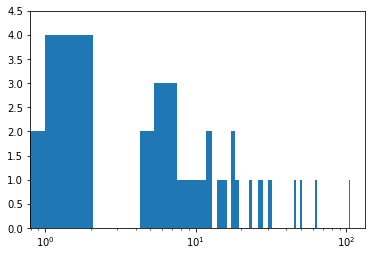

In [16]:
plt.hist(diff,bins=100)
plt.xscale('log')
plt.ylim(0,4.5)

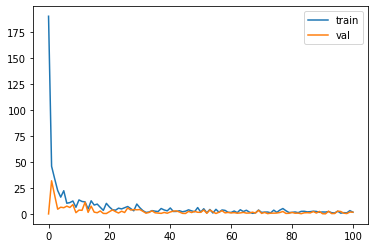

In [18]:
ep = np.arange(0, 101)
plt.plot(ep, history_train, label='train')
plt.plot(ep, history_val, label='val')
plt.legend()

In [19]:
np.shape(history_train), np.shape(history_val)

((101,), (101,))

(0.0, 60.0)

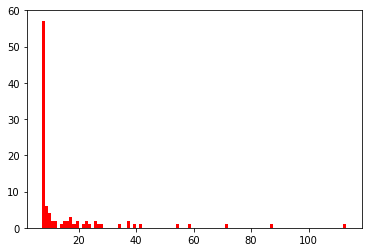

In [52]:
plt.hist(ytest, bins=len(ytest), color='red')
# plt.hist(ypred, bins=len(ypred), color='green')
plt.ylim(0,60)

In [49]:
len(ypred)==len(ytest)

True

In [51]:
len(ypred)

100